In [4]:
import numpy as np
import scipy as sp
import scipy.stats as stt
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 18

mpl_color = plt.rcParams['axes.prop_cycle'].by_key()['color']

%load_ext autoreload
%autoreload 2

## Application to a Gaussian case, using jet dataset parameters

In [23]:
x_min, x_max = 20, 60
E_min = -1000

In [24]:
def mu(x, x0):
    return x + 5*np.log(np.exp(x0/10) + np.exp(x/10)) - 5*np.log(1+np.exp((x0+x)/10))

x0 = 25

In [25]:
def sigma(x, N, S, C):
    return np.sqrt(N**2 + x*S**2 + (C*x)**2)

N = 4
S = 0.6
C = 0.05

In [130]:
N_data = int(5e5)
N_gen = int(1.2 * N_data)

In [131]:
np.random.seed(789)

x_data = stt.uniform.rvs(loc=x_min, scale=x_max-x_min, size=N_gen)
z_data = np.random.randn(N_gen)
y_data = z_data * sigma(x_data, N, S, C) + mu(x_data, x0)

In [132]:
x_data = x_data[:N_data]
y_data = y_data[:N_data]

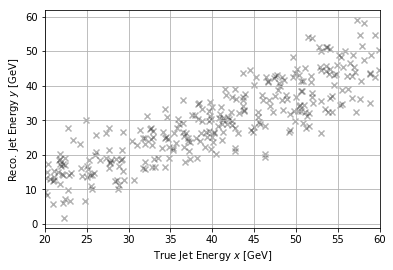

In [45]:
n_plot = 300

plt.scatter(x_data[:n_plot], y_data[:n_plot],c='k', alpha=0.3, marker='x', label="MC Samples")
plt.xlim([x_min, x_max])
plt.xlabel(r"True Jet Energy $x$ [GeV]")
plt.ylabel(r"Reco. Jet Energy $y$ [GeV]")
plt.grid()

plt.show()

## Train NN's

In [47]:
import keras

import keras.backend as K

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, ReLU, ELU, PReLU
from keras.callbacks import ModelCheckpoint

print("Using Keras version:", keras.__version__)

Using Keras version: 2.2.4


In [52]:
def scale(data, loc, scale):
    return (data - loc) / scale

def back_scale(data, loc, scale):
    return data * scale + loc

In [133]:
x_data = np.vstack((x_data, x_data**3)).T

In [134]:
x_loc, x_scale = np.mean(x_data, axis=0), np.std(x_data, axis=0)
y_loc, y_scale = np.mean(y_data), np.std(y_data)
y2_loc, y2_scale = np.mean(y_data*y_data), np.std(y_data*y_data)

### Standard Deviation-learning NN

In [135]:
mean_NN = Sequential([
        Dense(50, input_shape=(2,)),
        PReLU(),
        Dense(1)
    ])
mean_NN.compile(optimizer='adam',
                    loss='mse',)
mean_NN.fit(scale(x_data, x_loc, x_scale),
                                  scale(y_data, y_loc, y_scale),
                                  epochs=10, batch_size=int(N_data/20),
                                  verbose=False)

Epoch 1/10
500000/500000 [==============================] - 2s 3us/step - loss: 0.5138
Epoch 2/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.3174
Epoch 3/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.2601
Epoch 4/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.2513
Epoch 5/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.2490
Epoch 6/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.2478
Epoch 7/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.2472
Epoch 8/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.2468
Epoch 9/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.2466
Epoch 10/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.2464


In [136]:
myoutput_mean = back_scale(mean_NN.predict(scale(np.vstack((x_range, x_range**3)).T, x_loc, x_scale)), y_loc, y_scale).flatten()

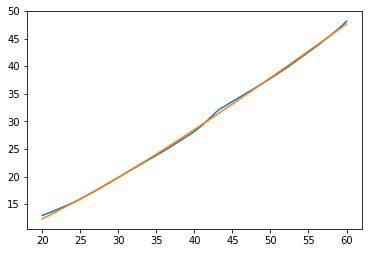

In [137]:
plt.plot(x_range,myoutput_mean,label="Learned Mean")
plt.plot(x_range, mu(x_range, x0), label=r"$\mu(x)$")
plt.xlabel("True")
plt.xlabel("Measured")
plt.legend()

In [139]:
moment2_NN = Sequential([
        Dense(50, input_shape=(2,)),
        PReLU(),
        Dense(1)
    ])
moment2_NN.compile(optimizer='adam',
                    loss='mse',)
moment2_NN.fit(scale(x_data, x_loc, x_scale),
                                  scale(y_data*y_data, y2_loc, y2_scale),
                                  epochs=10, batch_size=int(N_data/20),
                                  verbose=False)

Epoch 1/10
500000/500000 [==============================] - 2s 3us/step - loss: 0.7609
Epoch 2/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.4173
Epoch 3/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.2981
Epoch 4/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.2825
Epoch 5/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.2819
Epoch 6/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.2812
Epoch 7/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.2808
Epoch 8/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.2804
Epoch 9/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.2800
Epoch 10/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.2797


In [140]:
myoutput_moment2 = back_scale(moment2_NN.predict(scale(np.vstack((x_range, x_range**3)).T, x_loc, x_scale)), y2_loc, y2_scale).flatten()

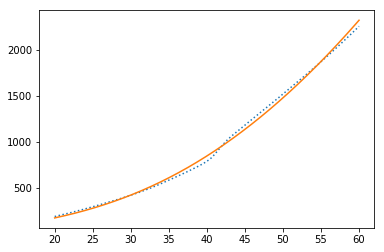

In [141]:
plt.plot(x_range,myoutput_moment2,linestyle=":",label="Learned Second Moment")
plt.plot(x_range,sigma(x_range, N, S, C)**2+mu(x_range, x0)**2,label="Exact Second Moment")
plt.xlabel("True Energy")
plt.xlabel("Measured Second Moment")
plt.legend()

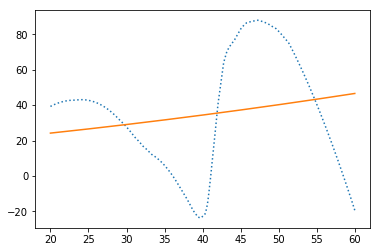

In [142]:
plt.plot(x_range,myoutput_moment2-mu(x_range, x0)**2,linestyle=":",label="Learned Standard Deviation (assume exact mean)")
plt.plot(x_range,sigma(x_range, N, S, C)**2,label="Exact Standard Deviation")
plt.xlabel("True Energy")
plt.xlabel("Measured Standard Deviation")
plt.legend()

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'Mean/Standard Deviation Learning')

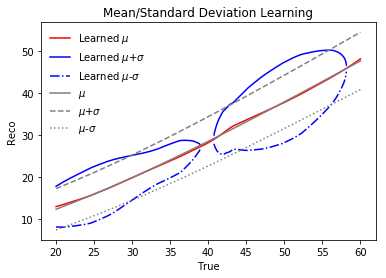

In [168]:
plt.plot(x_range,myoutput_mean,color='red',label=r'Learned $\mu$')
plt.plot(x_range,myoutput_mean+np.sqrt(myoutput_moment2 - myoutput_mean**2),color='blue',label=r'Learned $\mu$+$\sigma$')
plt.plot(x_range,myoutput_mean-np.sqrt(myoutput_moment2 - myoutput_mean**2),color='blue',linestyle="-.",label=r'Learned $\mu$-$\sigma$')
plt.plot(x_range, mu(x_range, x0), label=r"$\mu$",color='grey')
plt.plot(x_range, mu(x_range, x0)+sigma(x_range, N, S, C),color="grey",label=r"$\mu$+$\sigma$",linestyle="--")
plt.plot(x_range, mu(x_range, x0)-sigma(x_range, N, S, C),color="grey",label=r"$\mu$-$\sigma$",linestyle=":")
plt.legend(frameon=False)
plt.ylabel('Reco')
plt.xlabel('True')
plt.title('Mean/Standard Deviation Learning')

### IQR-learning NN

In [58]:
def GAE(y_true, y_pred, q = 0.5):
    sgn = -(y_true - y_pred) / K.abs(y_true - y_pred)
    return (0.5-sgn*0.5+sgn*q)*K.abs(y_true - y_pred)

In [60]:
mode_NN = Sequential([
        Dense(50, input_shape=(2,)),
        PReLU(),
        Dense(1)
    ])
mode_NN.compile(optimizer='adam',
                    loss=lambda y_true, y_pred: GAE(y_true, y_pred, q = 0.5))
mode_NN.fit(scale(x_data, x_loc, x_scale),
                                  scale(y_data, y_loc, y_scale),
                                  epochs=10, batch_size=int(N_data/20),
                                  verbose=False)

Epoch 1/10
500000/500000 [==============================] - 2s 3us/step - loss: 0.3474
Epoch 2/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.2423
Epoch 3/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.2019
Epoch 4/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.1988
Epoch 5/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.1983
Epoch 6/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.1980
Epoch 7/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.1978
Epoch 8/10
500000/500000 [==============================] - 1s 1us/step - loss: 0.1976
Epoch 9/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.1975
Epoch 10/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.1974


In [62]:
myoutput = back_scale(mode_NN.predict(scale(np.vstack((x_range, x_range**3)).T, x_loc, x_scale)), y_loc, y_scale).flatten()

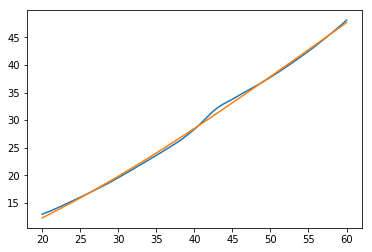

In [65]:
plt.plot(x_range,myoutput,label="Learned Median")
plt.plot(x_range, mu(x_range, x0), label=r"$\mu(x)$")
plt.xlabel("True")
plt.xlabel("Measured")
plt.legend()

In [66]:
print("First learn the 84% quantile")
mode_NN_84 = Sequential([
        Dense(50, input_shape=(2,)),
        PReLU(),
        Dense(1)
    ])
mode_NN_84.compile(optimizer='adam',
                    loss=lambda y_true, y_pred: GAE(y_true, y_pred, q = 0.84))
mode_NN_84.fit(scale(x_data, x_loc, x_scale),
                                  scale(y_data, y_loc, y_scale),
                                  epochs=10, batch_size=int(N_data/20),
                                  verbose=False)

print("Next, learn the 16% quantile")
mode_NN_16 = Sequential([
        Dense(50, input_shape=(2,)),
        PReLU(),
        Dense(1)
    ])
mode_NN_16.compile(optimizer='adam',
                    loss=lambda y_true, y_pred: GAE(y_true, y_pred, q = 0.16))
mode_NN_16.fit(scale(x_data, x_loc, x_scale),
                                  scale(y_data, y_loc, y_scale),
                                  epochs=10, batch_size=int(N_data/20),
                                  verbose=False)

Epoch 1/10
500000/500000 [==============================] - 2s 3us/step - loss: 0.3285
Epoch 2/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.2105
Epoch 3/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.1423
Epoch 4/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.1234
Epoch 5/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.1212
Epoch 6/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.1207
Epoch 7/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.1205
Epoch 8/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.1203
Epoch 9/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.1202
Epoch 10/10
500000/500000 [==============================] - 1s 2us/step - loss: 0.1202
Epoch 1/10
500000/500000 [==============================] - 2s 3us/step - loss: 0.4647
Epoch 2/10
500000/500000 [================

In [68]:
myoutput_84 = back_scale(mode_NN_84.predict(scale(np.vstack((x_range, x_range**3)).T, x_loc, x_scale)), y_loc, y_scale).flatten()
myoutput_16 = back_scale(mode_NN_16.predict(scale(np.vstack((x_range, x_range**3)).T, x_loc, x_scale)), y_loc, y_scale).flatten()

Text(0.5,1,'Median/Quantile Learning')

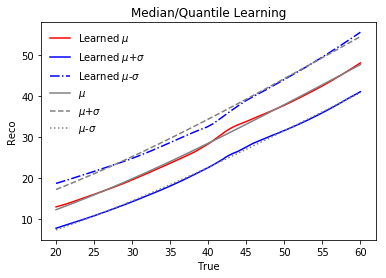

In [169]:
plt.plot(x_range,myoutput,color='red',label=r'Learned $\mu$')
plt.plot(x_range,myoutput_84,color='blue',label=r'Learned $\mu$+$\sigma$')
plt.plot(x_range,myoutput_16,color='blue',linestyle="-.",label=r'Learned $\mu$-$\sigma$')
plt.plot(x_range, mu(x_range, x0), label=r"$\mu$",color='grey')
plt.plot(x_range, mu(x_range, x0)+sigma(x_range, N, S, C),color="grey",label=r"$\mu$+$\sigma$",linestyle="--")
plt.plot(x_range, mu(x_range, x0)-sigma(x_range, N, S, C),color="grey",label=r"$\mu$-$\sigma$",linestyle=":")
plt.legend(frameon=False)
plt.ylabel('Reco')
plt.xlabel('True')
plt.title('Median/Quantile Learning')

## Now for the tracking case

In [204]:
def nsf(num, n=2):
    """n-Significant Figures"""
    numstr = ("{0:.%ie}" % (n-1)).format(num)
    return float(numstr)

2.0 -0.04 1.0 180.0
2.2 -0.021 1.0 1900.0
2.4 -0.012 1.0 30.0
2.7 -0.0052 1.0 93.0
2.9 -0.0029 1.0 3.0
3.1 -0.0016 1.0 3.6
3.3 -0.00061 0.99 1.8
3.6 -0.00074 0.99 1.2
3.8 0.001 0.99 1.0
4.0 -0.0011 0.99 1.0


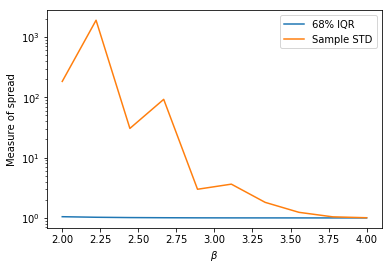

In [511]:
#We want to show that the IQR learning is robust to heavy tails.  This is a quick demo that the Crystal Ball is well-suited for this test.
IQRs = []
STDs = []
for be in np.linspace(2,4,10):
    rvals = stt.crystalball.rvs(beta=be, m=2, size=N_gen*5)
    print(nsf(be),nsf(np.quantile(rvals, 0.5)),nsf(0.5*(np.quantile(rvals, 0.84)-np.quantile(rvals, 0.16))),nsf(np.std(rvals)))
    IQRs+=[0.5*(np.quantile(rvals, 0.84)-np.quantile(rvals, 0.16))]
    STDs+=[np.std(rvals)]
    pass
plt.plot(np.linspace(2,4,10),IQRs,label="68% IQR")
plt.plot(np.linspace(2,4,10),STDs,label="Sample STD")
plt.xlabel(r'$\beta$')
plt.yscale("log")
plt.ylabel('Measure of spread')
plt.legend()

In [563]:
def mysigma(x):
    #roughly based on https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/PERF-2014-05/fig_15c.png
    return 0.03*(np.exp(20*np.log(x)/np.log(10)-4)/4+1)

def mysigma_linear(x):
    #roughly based on https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/PERF-2014-05/fig_15c.png
    return 0.03*(np.exp(-4*)np.exp(20*np.log(np.log(x)/np.log(10))/np.log(10))/4+1)

x2_min = np.log(7)/np.log(10)
x2_max = np.log(100)/np.log(10)
x2_range = np.linspace(x2_min, x2_max, 500)

SyntaxError: invalid syntax (<ipython-input-563-655b28513450>, line 7)

Text(0,0.5,'Fractional Momentum Resolution')

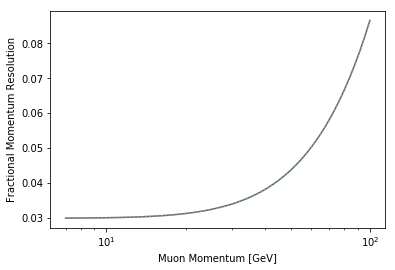

In [566]:
plt.plot(10**x2_range, mysigma_linear(10**x2_range), label=r"$\mu(x)$")
plt.plot(10**x2_range, mysigma(x2_range), label=r"$\mu(x)$",linestyle=":")
plt.xscale("log")
plt.xlabel("Muon Momentum [GeV]")
plt.ylabel("Fractional Momentum Resolution")

Let's start with one value of beta and then scan it later.

In [550]:
x_data = stt.uniform.rvs(loc=x2_min, scale=x2_max-x2_min, size=N_gen*5)
y_data = 1 + mysigma(x_data)*stt.crystalball.rvs(beta=3, m=2, size=N_gen*5)

x_data_forstd = x_data.copy()
y_data_forstd = y_data.copy()

In [551]:
x_data = x_data[:N_data]
y_data = y_data[:N_data]

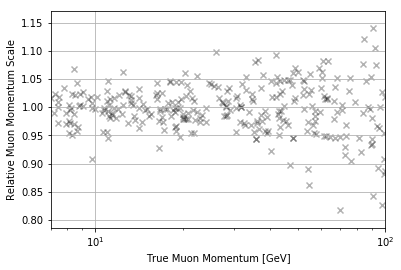

In [552]:
n_plot = 300

plt.scatter(10**x_data[:n_plot], y_data[:n_plot],c='k', alpha=0.3, marker='x', label="MC Samples")

plt.xlim([10**x2_min, 10**x2_max])
plt.xlabel(r"True Muon Momentum [GeV]")
plt.ylabel(r"Relative Muon Momentum Scale")
plt.grid()
plt.xscale("log")

plt.show()

In [553]:
x_data = np.vstack((x_data, x_data**3)).T

In [554]:
x_loc, x_scale = np.mean(x_data, axis=0), np.std(x_data, axis=0)
y_loc, y_scale = np.mean(y_data), np.std(y_data)

In [555]:
n_repeat = 25 #was 25
n_epochs = 50 # was 50

In [556]:
print("First learn the 84% quantile")
quantile84_NN_results = []

for i in range(n_repeat):
    
    print("Iteration %d: Starting..." % (i+1))

    quantile84_NN = Sequential([
        Dense(50, input_shape=(2,)),
        PReLU(),
        Dense(1)
    ])
    quantile84_cp = ModelCheckpoint("./NN_weights/muon_quantile84_NN_n%d.hdf5" % (i+1),
                              monitor='loss',
                              verbose=False,
                              save_best_only=True,
                              mode='min')
    quantile84_NN.compile(optimizer='adam',
                    loss=lambda y_true, y_pred: GAE(y_true, y_pred, q = 0.84))
    
    print("Iteration %d: Training..." % (i+1))
    
    quantile84_NN_history = quantile84_NN.fit(scale(x_data, x_loc, x_scale),
                                  scale(y_data, y_loc, y_scale),
                                  epochs=n_epochs, batch_size=int(N_data/20),
                                  callbacks=[quantile84_cp],
                                  verbose=False)
    
    print("Iteration %d: Evaluating..." % (i+1))

    quantile84_NN.load_weights("./NN_weights/muon_quantile84_NN_n%d.hdf5" % (i+1))

    quantile84_NN_results.append(back_scale(quantile84_NN.predict(scale(np.vstack((x2_range, x2_range**3)).T, x_loc, x_scale)), y_loc, y_scale).flatten())
    
    print("Iteration %d: Complete!\n" % (i+1))

quantile84_NN_results = np.array(quantile84_NN_results)

First learn the 84% quantile
Iteration 1: Starting...
Iteration 1: Training...
Iteration 1: Evaluating...
Iteration 1: Complete!

Iteration 2: Starting...
Iteration 2: Training...
Iteration 2: Evaluating...
Iteration 2: Complete!

Iteration 3: Starting...
Iteration 3: Training...
Iteration 3: Evaluating...
Iteration 3: Complete!

Iteration 4: Starting...
Iteration 4: Training...
Iteration 4: Evaluating...
Iteration 4: Complete!

Iteration 5: Starting...
Iteration 5: Training...
Iteration 5: Evaluating...
Iteration 5: Complete!

Iteration 6: Starting...
Iteration 6: Training...
Iteration 6: Evaluating...
Iteration 6: Complete!

Iteration 7: Starting...
Iteration 7: Training...
Iteration 7: Evaluating...
Iteration 7: Complete!

Iteration 8: Starting...
Iteration 8: Training...
Iteration 8: Evaluating...
Iteration 8: Complete!

Iteration 9: Starting...
Iteration 9: Training...
Iteration 9: Evaluating...
Iteration 9: Complete!

Iteration 10: Starting...
Iteration 10: Training...
Iteration 

In [557]:
print("Next, learn the 16% quantile")
quantile16_NN_results = []

for i in range(n_repeat):
    
    print("Iteration %d: Starting..." % (i+1))

    quantile16_NN = Sequential([
        Dense(50, input_shape=(2,)),
        PReLU(),
        Dense(1)
    ])
    quantile16_cp = ModelCheckpoint("./NN_weights/muon_quantile16_NN_n%d.hdf5" % (i+1),
                              monitor='loss',
                              verbose=False,
                              save_best_only=True,
                              mode='min')
    quantile16_NN.compile(optimizer='adam',
                    loss=lambda y_true, y_pred: GAE(y_true, y_pred, q = 0.16))
    
    print("Iteration %d: Training..." % (i+1))
    
    quantile16_NN_history = quantile16_NN.fit(scale(x_data, x_loc, x_scale),
                                  scale(y_data, y_loc, y_scale),
                                  epochs=n_epochs, batch_size=int(N_data/20),
                                  callbacks=[quantile16_cp],
                                  verbose=False)
    
    print("Iteration %d: Evaluating..." % (i+1))

    quantile16_NN.load_weights("./NN_weights/muon_quantile16_NN_n%d.hdf5" % (i+1))

    quantile16_NN_results.append(back_scale(quantile16_NN.predict(scale(np.vstack((x2_range, x2_range**3)).T, x_loc, x_scale)), y_loc, y_scale).flatten())
    
    print("Iteration %d: Complete!\n" % (i+1))

quantile16_NN_results = np.array(quantile16_NN_results)

Next, learn the 16% quantile
Iteration 1: Starting...
Iteration 1: Training...
Iteration 1: Evaluating...
Iteration 1: Complete!

Iteration 2: Starting...
Iteration 2: Training...
Iteration 2: Evaluating...
Iteration 2: Complete!

Iteration 3: Starting...
Iteration 3: Training...
Iteration 3: Evaluating...
Iteration 3: Complete!

Iteration 4: Starting...
Iteration 4: Training...
Iteration 4: Evaluating...
Iteration 4: Complete!

Iteration 5: Starting...
Iteration 5: Training...
Iteration 5: Evaluating...
Iteration 5: Complete!

Iteration 6: Starting...
Iteration 6: Training...
Iteration 6: Evaluating...
Iteration 6: Complete!

Iteration 7: Starting...
Iteration 7: Training...
Iteration 7: Evaluating...
Iteration 7: Complete!

Iteration 8: Starting...
Iteration 8: Training...
Iteration 8: Evaluating...
Iteration 8: Complete!

Iteration 9: Starting...
Iteration 9: Training...
Iteration 9: Evaluating...
Iteration 9: Complete!

Iteration 10: Starting...
Iteration 10: Training...
Iteration 

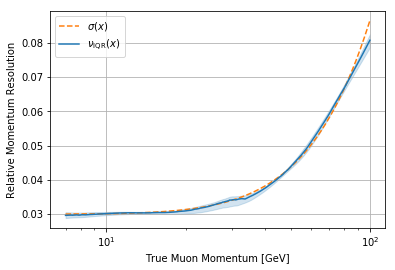

In [562]:
#mean_plot = plt.plot(x_range, x_mean_range / mu(x_range, x0),
#                     c=mpl_color[1], linestyle='--', label="Mean Response")

plt.plot(10**x2_range, mysigma(x2_range), label=r"$\sigma(x)$",c=mpl_color[1], linestyle='--')

#plt.plot([], [],c=mpl_color[2], alpha=1, label=r"Learned 68% Quantile")
#for i in range(n_repeat):
#    plt.plot(10**x2_range, 0.5*(quantile16_NN_results[i] - quantile84_NN_results[i]),c=mpl_color[2], alpha=0.2)

interquantile68 = 0.5*(quantile16_NN_results - quantile84_NN_results)

plt.plot(10**x2_range, np.median(interquantile68, axis=0).flatten(),c=mpl_color[0], label=r"$\nu_\mathrm{IQR}(x)$")
plt.fill_between(10**x2_range,
                 #(np.median(interquantile68, axis=0)-0.5*(np.quantile(interquantile68, 0.84, axis=0)-np.quantile(interquantile68, 0.16, axis=0))).flatten(),
                 #(np.median(interquantile68, axis=0)+0.5*(np.quantile(interquantile68, 0.84, axis=0)-np.quantile(interquantile68, 0.16, axis=0))).flatten(),
                 #color=mpl_color[0], alpha=0.2)    
                 (np.mean(interquantile68, axis=0)-(np.std(interquantile68, axis=0))).flatten(),
                 (np.mean(interquantile68, axis=0)+(np.std(interquantile68, axis=0))).flatten(),
                 color=mpl_color[0], alpha=0.2)     
    
#plt.xlim([x_range[0], x_range[-1]])
#plt.ylim([0.95, 1.25])
plt.xlabel(r"True Muon Momentum [GeV]")
plt.ylabel(r"Relative Momentum Resolution")
plt.grid()
plt.xscale("log")

plt.legend()

plt.savefig("./fig/muon_momentum2_resolution.png",bbox_inches="tight", dpi=400)
plt.savefig("./fig/muon_momentum2_resolution.pdf",bbox_inches="tight")
plt.show()

In [498]:
print(np.mean(np.median(interquantile68, axis=0).flatten()/mysigma(x2_range)))
print(np.std((y_data_forstd-1)/mu(x_data_forstd)))

1.0436454273588438
157.2621458718648


Now, let's scan $\beta$.

In [526]:
n_epochs = 10
n_takes = 1

std_vals = []
iqr_vals = []
for be in np.linspace(2,4,10):
    print("on beta = ",be)
    
    x_data_beta = stt.uniform.rvs(loc=x2_min, scale=x2_max-x2_min, size=N_gen*5)
    y_data_beta = 1 + mysigma(x_data_beta)*stt.crystalball.rvs(beta=be, m=2, size=N_gen*5)

    x_data_forstd_beta = x_data_beta.copy()
    y_data_forstd_beta = y_data_beta.copy()
    
    x_data_beta = x_data_beta[:N_data]
    y_data_beta = y_data_beta[:N_data]
    
    x_data_beta = np.vstack((x_data_beta, x_data_beta**3)).T
    x_loc_beta, x_scale_beta = np.mean(x_data_beta, axis=0), np.std(x_data_beta, axis=0)
    y_loc_beta, y_scale_beta = np.mean(y_data_beta), np.std(y_data_beta)

    print("First learn the 84% quantile")
    
    quantile84_NN_results_beta = []

    for i in range(n_takes):

        print("Iteration %d: Starting..." % (i+1))

        quantile84_NN = Sequential([
            Dense(50, input_shape=(2,)),
            PReLU(),
            Dense(1)
        ])
        quantile84_cp = ModelCheckpoint("./NN_weights/muon_quantile84_NN_n%d_beta.hdf5" % (i+1),
                                  monitor='loss',
                                  verbose=False,
                                  save_best_only=True,
                                  mode='min')
        quantile84_NN.compile(optimizer='adam',
                        loss=lambda y_true, y_pred: GAE(y_true, y_pred, q = 0.84))

        print("Iteration %d: Training..." % (i+1))

        quantile84_NN_history = quantile84_NN.fit(scale(x_data_beta, x_loc_beta, x_scale_beta),
                                      scale(y_data_beta, y_loc_beta, y_scale_beta),
                                      epochs=n_epochs, batch_size=int(N_data/20),
                                      callbacks=[quantile84_cp],
                                      verbose=False)

        print("Iteration %d: Evaluating..." % (i+1))

        quantile84_NN.load_weights("./NN_weights/muon_quantile84_NN_n%d_beta.hdf5" % (i+1))

        quantile84_NN_results_beta.append(back_scale(quantile84_NN.predict(scale(np.vstack((x2_range, x2_range**3)).T, x_loc_beta, x_scale_beta)), y_loc_beta, y_scale_beta).flatten())

        print("Iteration %d: Complete!\n" % (i+1))

    quantile84_NN_results_beta = np.array(quantile84_NN_results_beta)
    
    print("Next, learn the 16% quantile")
    quantile16_NN_results_beta = []

    for i in range(n_takes):

        print("Iteration %d: Starting..." % (i+1))

        quantile16_NN = Sequential([
            Dense(50, input_shape=(2,)),
            PReLU(),
            Dense(1)
        ])
        quantile16_cp = ModelCheckpoint("./NN_weights/muon_quantile16_NN_n%d_beta.hdf5" % (i+1),
                                  monitor='loss',
                                  verbose=False,
                                  save_best_only=True,
                                  mode='min')
        quantile16_NN.compile(optimizer='adam',
                        loss=lambda y_true, y_pred: GAE(y_true, y_pred, q = 0.16))

        print("Iteration %d: Training..." % (i+1))

        quantile16_NN_history = quantile16_NN.fit(scale(x_data_beta, x_loc_beta, x_scale_beta),
                                      scale(y_data_beta, y_loc_beta, y_scale_beta),
                                      epochs=n_epochs, batch_size=int(N_data/20),
                                      callbacks=[quantile16_cp],
                                      verbose=False)

        print("Iteration %d: Evaluating..." % (i+1))

        quantile16_NN.load_weights("./NN_weights/muon_quantile16_NN_n%d_beta.hdf5" % (i+1))

        quantile16_NN_results_beta.append(back_scale(quantile16_NN.predict(scale(np.vstack((x2_range, x2_range**3)).T, x_loc_beta, x_scale_beta)), y_loc_beta, y_scale_beta).flatten())

        print("Iteration %d: Complete!\n" % (i+1))

    quantile16_NN_results_beta = np.array(quantile16_NN_results_beta)
    
    interquantile68_beta = 0.5*(quantile16_NN_results_beta - quantile84_NN_results_beta)
    print(be,np.mean(np.median(interquantile68_beta, axis=0).flatten()/mysigma(x2_range)))
    print(be,np.std((y_data_forstd_beta-1)/mu(x_data_forstd_beta)))
    std_vals+=[np.std((y_data_forstd_beta-1)/mu(x_data_forstd_beta))]
    iqr_vals+=[np.mean(np.median(interquantile68_beta, axis=0).flatten()/mysigma(x2_range))]
    pass

on beta =  2.0
First learn the 84% quantile
Iteration 1: Starting...
Iteration 1: Training...
Iteration 1: Evaluating...
Iteration 1: Complete!

Next, learn the 16% quantile
Iteration 1: Starting...
Iteration 1: Training...
Iteration 1: Evaluating...
Iteration 1: Complete!

2.0 1.2417969229638102
2.0 371.87566186768987
on beta =  2.2222222222222223
First learn the 84% quantile
Iteration 1: Starting...
Iteration 1: Training...
Iteration 1: Evaluating...
Iteration 1: Complete!

Next, learn the 16% quantile
Iteration 1: Starting...
Iteration 1: Training...
Iteration 1: Evaluating...
Iteration 1: Complete!

2.2222222222222223 1.019034931682831
2.2222222222222223 25.318054546331723
on beta =  2.4444444444444446
First learn the 84% quantile
Iteration 1: Starting...
Iteration 1: Training...
Iteration 1: Evaluating...
Iteration 1: Complete!

Next, learn the 16% quantile
Iteration 1: Starting...
Iteration 1: Training...
Iteration 1: Evaluating...
Iteration 1: Complete!

2.4444444444444446 1.020

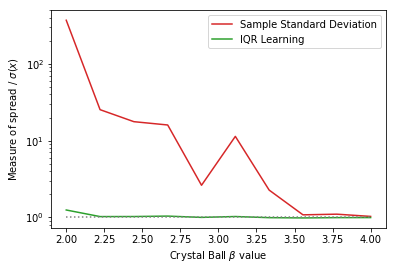

In [531]:
#plt.plot(np.linspace(2,4,10),std_vals)
#plt.plot(np.linspace(2,4,10),IQRs,label="68% IQR")
plt.plot(np.linspace(2,4,10),std_vals,label="Sample Standard Deviation",color=mpl_color[3])
plt.plot(np.linspace(2,4,10),iqr_vals,label="IQR Learning",color=mpl_color[2])
plt.plot(np.linspace(2,4,10),np.ones(len(np.linspace(2,4,10))),color='gray',linestyle=":")
plt.xlabel(r'Crystal Ball $\beta$ value')
plt.yscale("log")
plt.ylabel('Measure of spread / $\sigma(x)$')
plt.legend()
plt.savefig("./fig/muon_momentum_resolution_betascan.png",bbox_inches="tight", dpi=400)
plt.savefig("./fig/muon_momentum_resolution_betascan.pdf",bbox_inches="tight")